In [14]:
import os
import cv2
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
import mediapipe as mp
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


In [15]:
# Пути к данным
path = "/Users/arsenfatkhulllin/Downloads"
source_directory = f'{path}/dataset_v2/train'
test_directory = f'{path}/dataset_v2/test'
val_directory = f'{path}/dataset_v2/val'
video_extensions = {'.mp4', '.avi', '.mov', '.mkv', '.flv', '.wmv'}


In [16]:
# Получаем название классов в алфавитном порядке.
class_names = sorted([d for d in os.listdir(source_directory) if os.path.isdir(os.path.join(source_directory, d))])
# количество классов
num_classes = len(class_names)

In [17]:
# Считает, сколько видео в каждом классе
folders_by_video_count = defaultdict(list) #словарь где ключ - кол-во видео, значение - классы
for foldername in class_names:
    folderpath = os.path.join(source_directory, foldername) #
    count_videos = sum(1 for fname in os.listdir(folderpath) if os.path.splitext(fname)[1].lower() in video_extensions)
    if count_videos > 0:
        folders_by_video_count[count_videos].append(foldername)

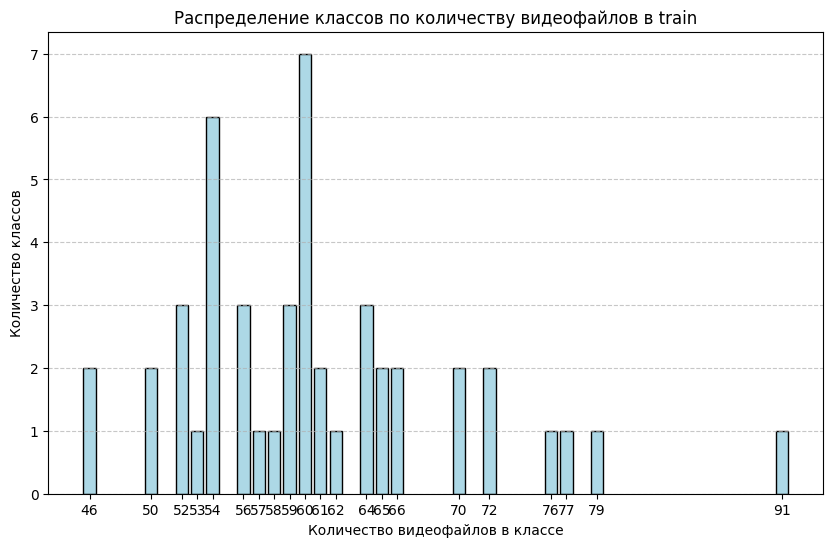

In [18]:
#TODO перевернуть
counts = list(folders_by_video_count.keys())
num_folders = [len(folders_by_video_count[count]) for count in counts]
if counts:
    sorted_pairs = sorted(zip(counts, num_folders))
    sorted_counts, sorted_num_folders = zip(*sorted_pairs)
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_counts, sorted_num_folders, color='lightblue', edgecolor='black')
    plt.xlabel('Количество видеофайлов в классе')
    plt.ylabel('Количество классов')
    plt.title('Распределение классов по количеству видеофайлов в train')
    plt.xticks(sorted_counts)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [19]:

# для руки 21 точка,
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)
# для позы 33 точки
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    smooth_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

I0000 00:00:1761228148.549832 2481138 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1
I0000 00:00:1761228148.567697 2481138 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1
W0000 00:00:1761228148.573876 2482417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761228148.591246 2482417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [20]:
SEQUENCE_LENGTH = 30 #кол-во кадров на одно видео
NUM_FEATURES_HANDS = 21*3*2 #Кол-во точек для рук
NUM_FEATURES_POSE = 33*4  #кол-во точек для позы
TOTAL_FEATURES = NUM_FEATURES_HANDS + NUM_FEATURES_POSE # кол-во точек всего
CACHE_PATH = "dataset_cache.npy"
CACHE_LABELS_PATH = "labels_cache.npy"


def normalize_and_scale_hands(frame):
    if all(x == 0 for x in frame):
        return frame
    # Преобразовать плоский список в массив формы (N, 3),
    # где N — количество ключевых точек
    coords = np.aнапrray(frame).reshape(-1,3)
    wrist_x, wrist_y, wrist_z = coords[0]
    #Центрирование
    coords -= [wrist_x, wrist_y, wrist_z]

    scale = np.linalg.norm(coords[0] - coords[9])
    if scale > 0:
        coords /= scale
    # Вернуть плоский одномерный вектор
    return coords.flatten()

def extract_pose_features(frame):
    #читает изображение в rgb
    results_pose = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    if results_pose.pose_landmarks:
        coords = []
        #Собираем по каждому из 33 ориентиру 4 значения
        for lm in results_pose.pose_landmarks.landmark:
            coords.extend([lm.x, lm.y, lm.z, lm.visibility])
        coords = np.array(coords, dtype=np.float32)
        #точка для центрирования
        base_idx = 23
        #берем его координату при помощи среза
        base_x, base_y, base_z = coords[4*base_idx:4*base_idx+3]

        #перевод в формат (33,4)
        coords_reshaped = coords.reshape(-1,4)
        #центрирование относительно 23 точки
        coords_reshaped[:,:3] -= [base_x, base_y, base_z]

         # Масштаб — расстояние от таза до головы/носа (индекс 0 = Nose).
        # Это делает признаки инвариантными к масштабу (рост, дистанция до камеры).
        head_idx = 0
        head_dist = np.linalg.norm(coords_reshaped[head_idx, :3])
        # масштабируем только xyz visibiity не трогаем
        if head_dist > 0:
            coords_reshaped[:,:3] /= head_dist
        return coords_reshaped.flatten()
    else:
        return np.zeros(33*4, dtype=np.float32)


def extract_sequence_from_video(video_path):

    # открываем видео для покадрового чтения
    cap = cv2.VideoCapture(video_path)
    # список для хранения векторных признаков кадра
    frames = []
    # счетчик кадров
    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read() # чтения кадра
        if not ret:
            break

        # берем каждый 2 кадр
        if frame_idx % 2 == 0:
            # руки
            # TODO сделать функцию для извлечения frame рук
            results_hands = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            hand_landmarks = []
            for h_idx in range(2):
                if results_hands.multi_hand_landmarks and h_idx < len(results_hands.multi_hand_landmarks):
                    for lm in results_hands.multi_hand_landmarks[h_idx].landmark:
                        # если найдена рука то зписываем его координаты
                        hand_landmarks.extend([lm.x, lm.y, lm.z])
                else:
                    # иначе заполняем нулями
                    hand_landmarks.extend([0.0]*63)

            # Нормализация рук: центрируем по запястью и масштабируем по сегменту 0→9 (MCP среднего пальца)
            # Это делает признаки инвариантными к сдвигу и масштабу, возвращает плоский np.ndarray
            hand_features = normalize_and_scale_hands(hand_landmarks)
            # извлечение точек позы
            pose_features = extract_pose_features(frame)
            # Объединение признаков
            feature_vector = np.concatenate([hand_features, pose_features])
            frames.append(feature_vector)
        # как только набираем нужное количество кадров, прекращаем чтение
        frame_idx += 1
        if len(frames) >= SEQUENCE_LENGTH:
            break
    cap.release()   # Освобождаем ресурсы видеодекодера
    # Дополнение нулями, если не хвататет кол-во кадров
    if len(frames) < SEQUENCE_LENGTH:
        pad = np.zeros(TOTAL_FEATURES, dtype=np.float32)
        frames.extend([pad]*(SEQUENCE_LENGTH - len(frames)))
     # Возвращаем тензор формы (SEQUENCE_LENGTH, TOTAL_FEATURES), dtype float32
    return np.array(frames, dtype=np.float32)


# Загружает датасет из каталогов класса:
    # directory/
    #   ├─ <class_name_1>/*.mp4|*.avi|...
    #   ├─ <class_name_2>/*.mp4|*.avi|...
    #   └─ ...
def load_data_from_directory(directory, selected_classes, video_extensions, augment=False):
    sequences = [] # накопитель признаковых последовательностей по видео
    labels = []  # накопитель меток классов, выровненных по sequences
    for class_idx, class_name in enumerate(selected_classes): # Перебор классов в заданном порядке; индекс class_idx будет использоваться как целевая метка
        class_dir = os.path.join(directory, class_name) # путь к папке конкретного класса
        video_files = [f for f in os.listdir(class_dir) if os.path.splitext(f)[1].lower() in video_extensions] # Список файлов видео по допустимым расширениям
        for video_file in video_files: # Обрабатываем каждое видео этого класса
            seq = extract_sequence_from_video(os.path.join(class_dir, video_file)) # Извлекаем последовательность признаков
            if augment: # Опциональная аугментация (шум/смещение и т.п.) — только для train
                seq = augment_sequence(seq)

            # Добавляем признаки и соответствующую метку класса
            sequences.append(seq)
            labels.append(class_idx)
    return np.array(sequences), np.array(labels)


def augment_sequence(seq):
    """Data augmentation — шум + небольшое смещение"""
    noise = np.random.normal(0, 0.01, seq.shape)
    shift = np.random.uniform(-0.05, 0.05, (1, seq.shape[1]))
    return seq + noise + shift


In [21]:
selected_classes = class_names[:5]


# selected_classes = ['your', 'yes', 'no', 'help', 'right']  # нужные тебе классы

num_classes = len(selected_classes)

In [23]:

# загруза данных

X_train, y_train = load_data_from_directory(source_directory, selected_classes, video_extensions, augment=True)
X_val, y_val = load_data_from_directory(val_directory, selected_classes, video_extensions)
X_test, y_test = load_data_from_directory(test_directory, selected_classes, video_extensions)

In [24]:
from tensorflow.keras.utils import to_categorical
#кэф сглаживания
label_smoothing_factor = 0.1

# Перевод целочисленных меток в one-hot: форма (N, num_classes)
y_train_cat = to_categorical(y_train)
y_train_cat = y_train_cat * (1 - label_smoothing_factor) + (label_smoothing_factor / y_train_cat.shape[1])

y_val_cat = to_categorical(y_val)
y_val_cat = y_val_cat * (1 - label_smoothing_factor) + (label_smoothing_factor / y_val_cat.shape[1])

y_test_cat = to_categorical(y_test)
y_test_cat = y_test_cat * (1 - label_smoothing_factor) + (label_smoothing_factor / y_test_cat.shape[1])


In [25]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Dropout,
    Bidirectional, LSTM, GRU, MultiHeadAttention, Dense, LayerNormalization,
    GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate
)
from tensorflow.keras.models import Model
def build_model(sequence_len, num_features, num_classes, d_model=256, num_heads=4):
    inputs = Input(shape=(sequence_len, num_features))

    # Первый блок сверточных слоев выделяет локальные шаблоны
    x = Conv1D(128, 5, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x); x = Activation('relu')(x) # нормализация ускоряет обучение
    x = Conv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x); x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)  # уменьшаем длину последовательности в 2 раза
    x = Dropout(0.2)(x)

    # Второй блок сверточных слоев - более глубокие признаки
    x = Conv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x); x = Activation('relu')(x)
    x = Conv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x); x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)

    #  двунаправленная LSTM запоминает долгосрочные зависимости
    x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(x)
    # двунаправленный GRU обрабатывает более короткие зависимости с меньшей вычислительной стоимостью
    x = Bidirectional(GRU(192, return_sequences=True, dropout=0.2))(x)

    # Проекция в d_model для внимания
    proj = Dense(d_model)(x)

    # каждый таймстеп “смотрит” на всю последовательность, чтобы собрать контекст из других позиций.
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, dropout=0.1)(proj, proj)
    x = LayerNormalization(epsilon=1e-5)(proj + attn_out)

    # блок — позиционно-основная FFN трансформера. Он по каждому таймстепу независимо делает расширение признаков до 4·d_model через ReLU, затем сжимает обратно до d_model, применяет дропаут для регуляризации и добавляет residual с последующей LayerNorm для стабильного градиентного потока
    ff = Dense(4*d_model, activation='relu')(x)
    ff = Dropout(0.1)(ff)
    ff = Dense(d_model)(ff)
    x = LayerNormalization(epsilon=1e-5)(x + ff)

    # Комбинированный пуллинг
    avg = GlobalAveragePooling1D()(x)
    mx = GlobalMaxPooling1D()(x)
    x = Concatenate()([avg, mx])

    #
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Использование
model9 = build_model(SEQUENCE_LENGTH, TOTAL_FEATURES, num_classes)
model9.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 258)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 128)   │    165,120 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 30, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 128)   │     49,152 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 30, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 15, 128)   │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 15, 128)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 15, 256)   │     98,304 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 256)   │      1,024 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 15, 256)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 15, 256)   │    196,608 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 256)   │      1,024 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 15, 256)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 7, 256)    │          0 │ activation_3[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7, 256)    │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 7, 512)    │  1,050,624 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 7, 384)    │    813,312 │ bidirectional[0]

 Total params: 3,429,381 (13.08 MB)

 Trainable params: 3,427,845 (13.08 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [26]:

callbacks = [
    EarlyStopping(patience=7,restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6), #сли выбранная метрика не улучшается 3 эпохи, уменьшает текущий learning rate в 2 раза (
    ModelCheckpoint('best_model.h5', save_best_only=True)
]


In [27]:
history3 = model9.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val_cat),
    callbacks=callbacks
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2786 - loss: 1.7490

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.3285 - loss: 1.6258 - val_accuracy: 0.1250 - val_loss: 2.1297 - learning_rate: 3.0000e-04
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5110 - loss: 1.2704

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.5271 - loss: 1.2542 - val_accuracy: 0.1750 - val_loss: 1.7613 - learning_rate: 3.0000e-04
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6237 - loss: 1.0610

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.6534 - loss: 1.0370 - val_accuracy: 0.4750 - val_loss: 1.3026 - learning_rate: 3.0000e-04
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7391 - loss: 0.9112

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.7978 - loss: 0.8194 - val_accuracy: 0.6750 - val_loss: 1.1048 - learning_rate: 3.0000e-04
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8520 - loss: 0.7598 - val_accuracy: 0.5750 - val_loss: 1.2563 - learning_rate: 3.0000e-04
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9097 - loss: 0.6326 - val_accuracy: 0.6250 - val_loss: 1.1466 - learning_rate: 3.0000e-04
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9567 - loss: 0.5776 - val_accuracy: 0.5750 - val_loss: 1.2523 - learning_rate: 3.0000e-04
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9750 - loss: 0.5047

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9783 - loss: 0.5045 - val_accuracy: 0.7750 - val_loss: 0.8529 - learning_rate: 1.5000e-04
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9872 - loss: 0.4854

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9711 - loss: 0.5074 - val_accuracy: 0.8000 - val_loss: 0.7928 - learning_rate: 1.5000e-04
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9965 - loss: 0.4598

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9964 - loss: 0.4667 - val_accuracy: 0.7500 - val_loss: 0.7576 - learning_rate: 1.5000e-04
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9873 - loss: 0.4725

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.9928 - loss: 0.4721 - val_accuracy: 0.8500 - val_loss: 0.6758 - learning_rate: 1.5000e-04
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9783 - loss: 0.4842 - val_accuracy: 0.7750 - val_loss: 0.7996 - learning_rate: 1.5000e-04
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.9964 - loss: 0.4555 - val_accuracy: 0.7500 - val_loss: 0.8633 - learning_rate: 1.5000e-04
Epoch 14/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9964 - loss: 0.4572 - val_accuracy: 0.8250 - val_loss: 0.7277 - learning_rate: 1.5000e-04
Epoch 15/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9883 - loss: 0.4732

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9928 - loss: 0.4715 - val_accuracy: 0.9000 - val_loss: 0.6005 - learning_rate: 7.5000e-05
Epoch 16/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.4500

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 0.4516 - val_accuracy: 0.9250 - val_loss: 0.5343 - learning_rate: 7.5000e-05
Epoch 17/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9902 - loss: 0.4458 

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9964 - loss: 0.4460 - val_accuracy: 0.9250 - val_loss: 0.5006 - learning_rate: 7.5000e-05
Epoch 18/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.4428

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 0.4417 - val_accuracy: 0.9750 - val_loss: 0.4775 - learning_rate: 7.5000e-05
Epoch 19/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9954 - loss: 0.4513

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.9964 - loss: 0.4512 - val_accuracy: 1.0000 - val_loss: 0.4347 - learning_rate: 7.5000e-05
Epoch 20/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9996 - loss: 0.4485

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.9964 - loss: 0.4506 - val_accuracy: 1.0000 - val_loss: 0.4216 - learning_rate: 7.5000e-05
Epoch 21/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.4496

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.4511 - val_accuracy: 1.0000 - val_loss: 0.4152 - learning_rate: 7.5000e-05
Epoch 22/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.4479

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 0.4496 - val_accuracy: 1.0000 - val_loss: 0.4135 - learning_rate: 7.5000e-05
Epoch 23/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 1.0000 - loss: 0.4448 - val_accuracy: 1.0000 - val_loss: 0.4166 - learning_rate: 7.5000e-05
Epoch 24/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.4542

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.4503 - val_accuracy: 1.0000 - val_loss: 0.4121 - learning_rate: 7.5000e-05
Epoch 25/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.4404

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.4415 - val_accuracy: 1.0000 - val_loss: 0.4105 - learning_rate: 7.5000e-05
Epoch 26/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.4435 

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 0.4431 - val_accuracy: 1.0000 - val_loss: 0.4080 - learning_rate: 7.5000e-05
Epoch 27/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.4340

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 0.4408 - val_accuracy: 1.0000 - val_loss: 0.4063 - learning_rate: 7.5000e-05
Epoch 28/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.4399

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 1.0000 - loss: 0.4413 - val_accuracy: 1.0000 - val_loss: 0.4056 - learning_rate: 7.5000e-05
Epoch 29/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.4462

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 0.4423 - val_accuracy: 1.0000 - val_loss: 0.4054 - learning_rate: 7.5000e-05
Epoch 30/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 0.4384 - val_accuracy: 1.0000 - val_loss: 0.4075 - learning_rate: 7.5000e-05
Epoch 31/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 1.0000 - loss: 0.4367 - val_accuracy: 1.0000 - val_loss: 0.4078 - learning_rate: 7.5000e-05
Epoch 32/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9964 - loss: 0.4461 - val_accuracy: 1.0000 - val_loss: 0.4070 - learning_rate: 7.5000e-05
Epoch 33/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 0.4424 - val_accuracy: 1.0000 - val_loss: 0.4084 - learning_rate: 3.7500e-05
Epoch 34/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 1.0000 - loss: 0.4346 - val_accuracy: 1.0000 - val_loss: 0.4103 - learning_rate: 3.7500e-05
Epoch 35/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 0.

In [28]:
from sklearn.metrics import classification_report

y_pred = model9.predict(X_test)
y_true_labels = np.argmax(y_test_cat, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=selected_classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step

Classification Report:
              precision    recall  f1-score   support

        your       1.00      1.00      1.00         6
         yes       1.00      1.00      1.00         6
          no       1.00      1.00      1.00         6
        help       1.00      1.00      1.00         7
       right       1.00      1.00      1.00         7

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



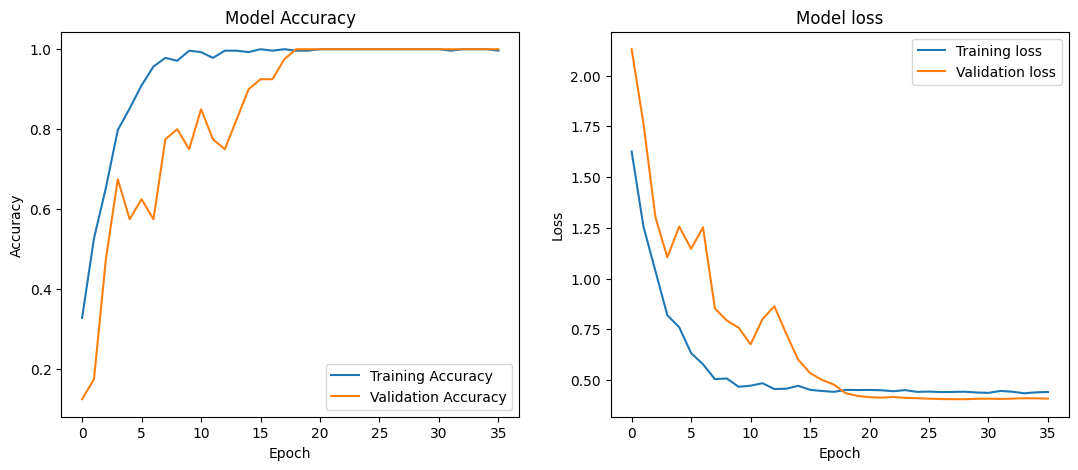

In [29]:


fig, axe = plt.subplots(1, 2, figsize=(13, 5))

axe[0].plot(history3.history['accuracy'], label='Training Accuracy')
axe[0].plot(history3.history['val_accuracy'], label='Validation Accuracy')
axe[0].set_title('Model Accuracy')
axe[0].set_ylabel('Accuracy')
axe[0].set_xlabel('Epoch')
axe[0].legend()

axe[1].plot(history3.history['loss'], label='Training loss')
axe[1].plot(history3.history['val_loss'], label='Validation loss')
axe[1].set_title('Model loss')
axe[1].set_ylabel('Loss')
axe[1].set_xlabel('Epoch')
axe[1].legend()
plt.show()

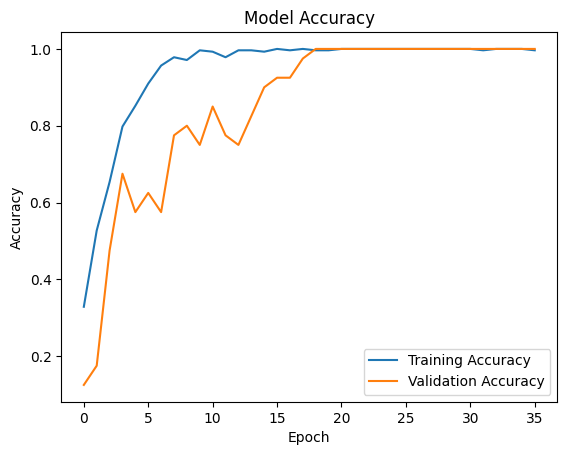

In [30]:
import matplotlib.pyplot as plt

plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [31]:
print("Train classes:", np.unique(np.argmax(y_train_cat, axis=1), return_counts=True))
print("Val classes:", np.unique(np.argmax(y_val_cat, axis=1), return_counts=True))


Train classes: (array([0, 1, 2, 3, 4]), array([52, 54, 52, 60, 59]))
Val classes: (array([0, 1, 2, 3, 4]), array([7, 8, 8, 9, 8]))
